In [1]:

#clear the output 
!rm -rf /kaggle/working/*

In [2]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 16.7 MB/s eta 0:00:00


In [3]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [4]:
import numpy as np
import pandas as pd
import os
import shutil
import cv2
import yaml
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm.auto import tqdm
import shutil
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
images_path = Path('/kaggle/input/videodata/videodataset/img') 
labels_path = Path('/kaggle/input/videodata/videodataset/labels') 
dataset_classes = ['car','truck', 'accident', 'motorcycles', 'things']

In [6]:
ims = sorted(list(images_path.glob('*')))
labels = sorted(list(labels_path.glob('*')))
pairs = list(zip(ims,labels))
pairs[:2]

[(PosixPath('/kaggle/input/videodata/videodataset/img/w1-12_frame0000.jpg'),
  PosixPath('/kaggle/input/videodata/videodataset/labels/w1-12_frame0000.txt')),
 (PosixPath('/kaggle/input/videodata/videodataset/img/w1-12_frame0001.jpg'),
  PosixPath('/kaggle/input/videodata/videodataset/labels/w1-12_frame0001.txt'))]

In [7]:
train, test = train_test_split(pairs,test_size=0.1,shuffle=True)
len(train), len(test)

(2997, 334)

In [8]:
train_path = Path('train').resolve()
train_path.mkdir(exist_ok=True)
valid_path = Path('valid').resolve()
valid_path.mkdir(exist_ok=True)

In [9]:
print(valid_path)
print(train_path)

/kaggle/working/valid
/kaggle/working/train


In [10]:
for t_img, t_lb in tqdm(train):
    im_path = train_path / t_img.name
    lb_path = train_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/2997 [00:00<?, ?it/s]

In [11]:
for t_img, t_lb in tqdm(test):
    im_path = valid_path / t_img.name
    lb_path = valid_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/334 [00:00<?, ?it/s]

In [12]:
print(" splitting complete.")

 splitting complete.


In [13]:
#Define the data dictionary
data = {
    'train': '/kaggle/working/train',
    'val': '/kaggle/working/valid',
    'nc': 5,  # number of classes
    'names': ['car','truck', 'accident', 'motorcycles', 'things']
}

# Save to data.yaml
with open('/kaggle/working/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

print("data.yaml file created successfully.")

data.yaml file created successfully.


In [14]:
!cat data.yaml
print("data.yaml file created successfully.")

names:
- car
- truck
- accident
- motorcycles
- things
nc: 5
train: /kaggle/working/train
val: /kaggle/working/valid
data.yaml file created successfully.


In [15]:
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.7MB/s]


In [16]:
results = model.train(data="/kaggle/working/data.yaml",  
                      epochs=32, imgsz= 640, device=[0, 1], auto_augment= 'randaugment',show=True )  # train the model

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/data.yaml, epochs=32, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=True, save_frames=False, save_txt=Fa

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

In [17]:
valid_results = model.val()

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/valid.cache... 334 images, 0 backgrounds, 0 corrupt: 100%|██████████| 334/334 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.98it/s]


                   all        334       1301      0.954      0.929      0.965      0.762
                   car        295        928      0.966      0.887      0.975       0.76
                 truck        130        216      0.958      0.957      0.967      0.802
              accident        122        127       0.96      0.939      0.968      0.799
           motorcycles         23         30      0.933      0.931      0.952      0.685
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train2


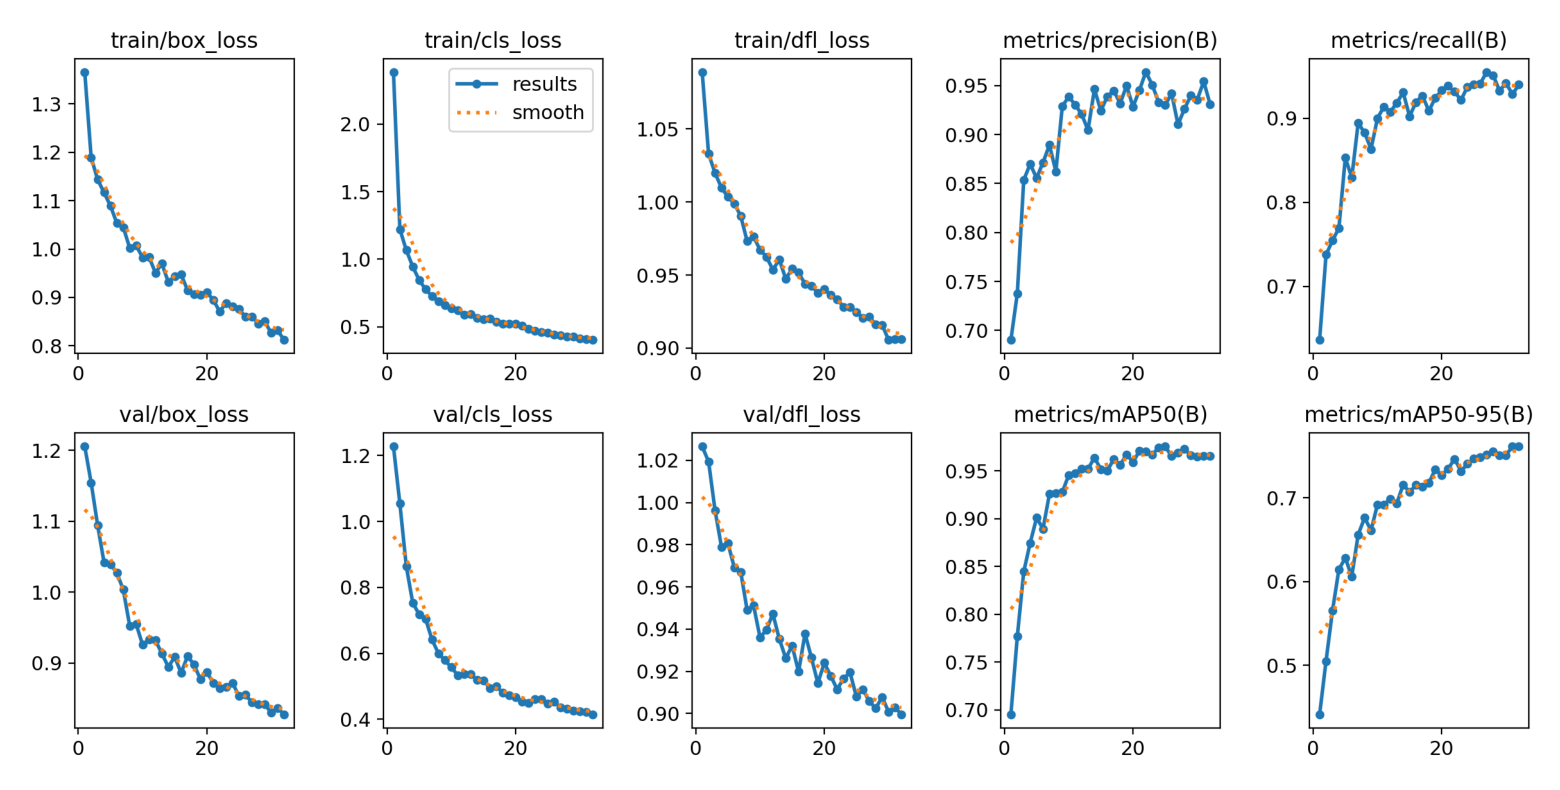

In [18]:
img_path = '/kaggle/working/runs/detect/train/results.png'
img = plt.imread(img_path)

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis(False)
plt.show()

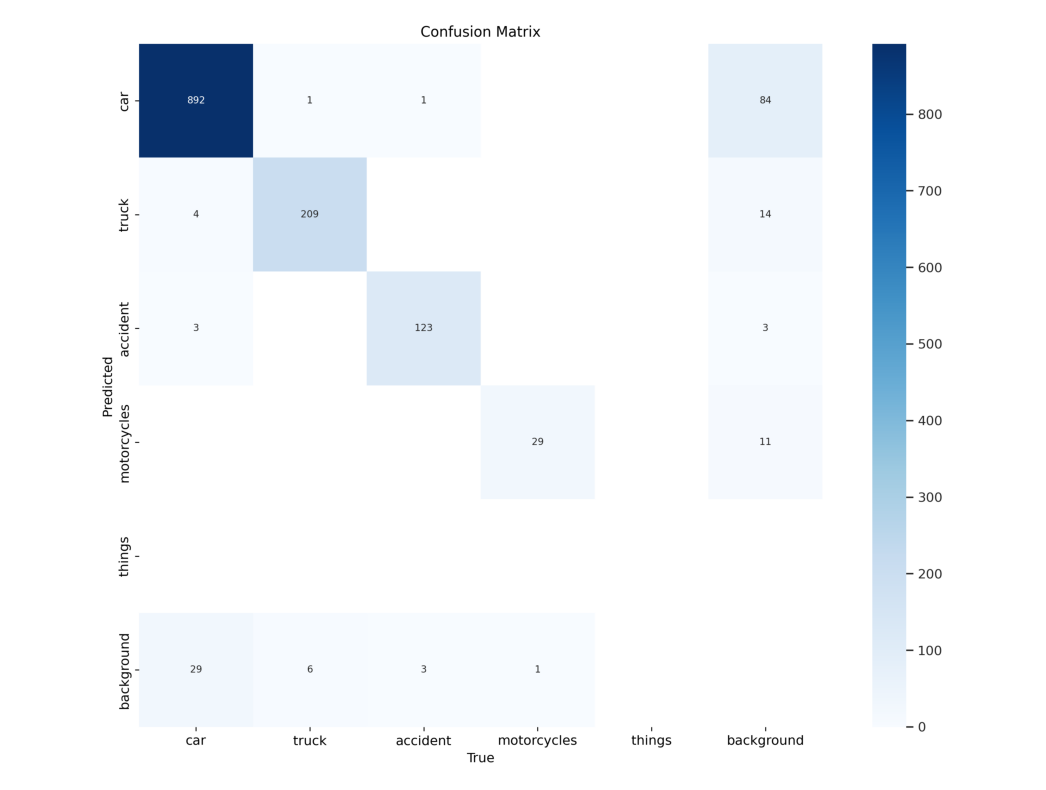

In [19]:
img_path = '/kaggle/working/runs/detect/train/confusion_matrix.png'
img = plt.imread(img_path)

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis(False)
plt.show()

In [20]:
Result_Final_model = pd.read_csv('//kaggle/working/runs/detect/train/results.csv')
Result_Final_model

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,48.6314,1.36609,2.38547,1.08899,0.69023,0.63633,0.69551,0.44155,1.20539,1.22807,1.02664,0.000237,0.000237,0.000237
1,2,89.7940,1.18936,1.22196,1.03291,0.73771,0.73773,0.77688,0.50517,1.15423,1.05403,1.01937,0.000460,0.000460,0.000460
2,3,131.1470,1.14397,1.06680,1.01986,0.85365,0.75460,0.84451,0.56514,1.09447,0.86384,0.99637,0.000669,0.000669,0.000669
3,4,171.5450,1.11694,0.94577,1.00974,0.86992,0.76938,0.87451,0.61460,1.04194,0.75347,0.97903,0.000648,0.000648,0.000648
4,5,211.4850,1.08944,0.84627,1.00345,0.85555,0.85320,0.90085,0.62837,1.03916,0.71816,0.98075,0.000626,0.000626,0.000626
5,6,251.3630,1.05346,0.77703,0.99884,0.87156,0.82964,0.88937,0.60618,1.02681,0.70414,0.96923,0.000604,0.000604,0.000604
6,7,291.6150,1.04514,0.72800,0.99038,0.88940,0.89456,0.92576,0.65613,1.00327,0.64168,0.96714,0.000581,0.000581,0.000581
7,8,331.6930,1.00216,0.68985,0.97307,0.86230,0.88291,0.92641,0.67634,0.95230,0.59964,0.94897,0.000559,0.000559,0.000559
8,9,371.5210,1.00751,0.65831,0.97625,0.92900,0.86355,0.92764,0.66123,0.95476,0.57900,0.95121,0.000537,0.000537,0.000537
9,10,411.2190,0.98243,0.63726,0.96725,0.93868,0.90017,0.94559,0.69200,0.92572,0.55768,0.93608,0.000515,0.000515,0.000515


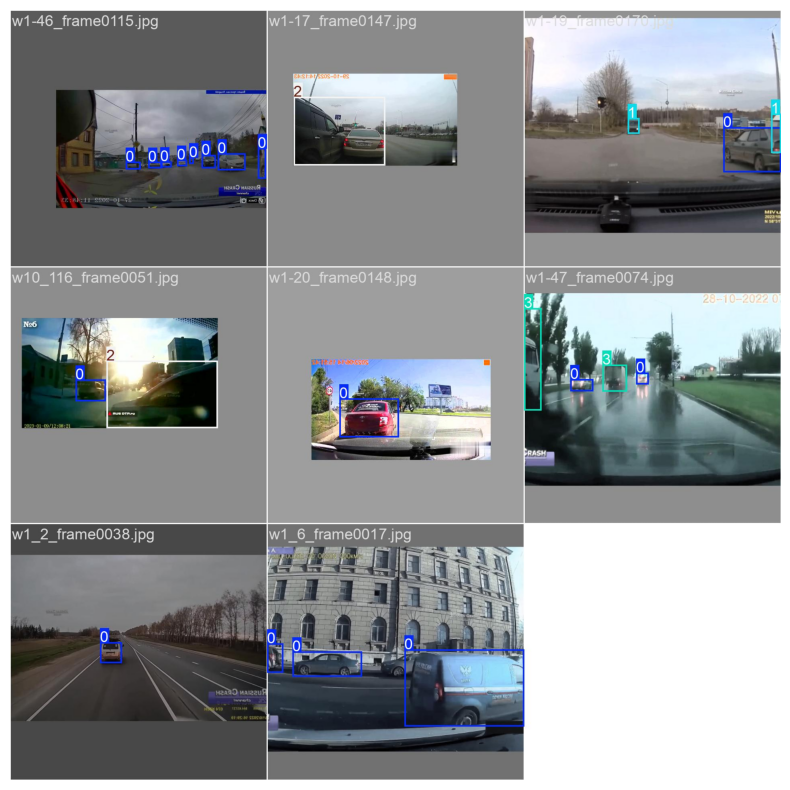

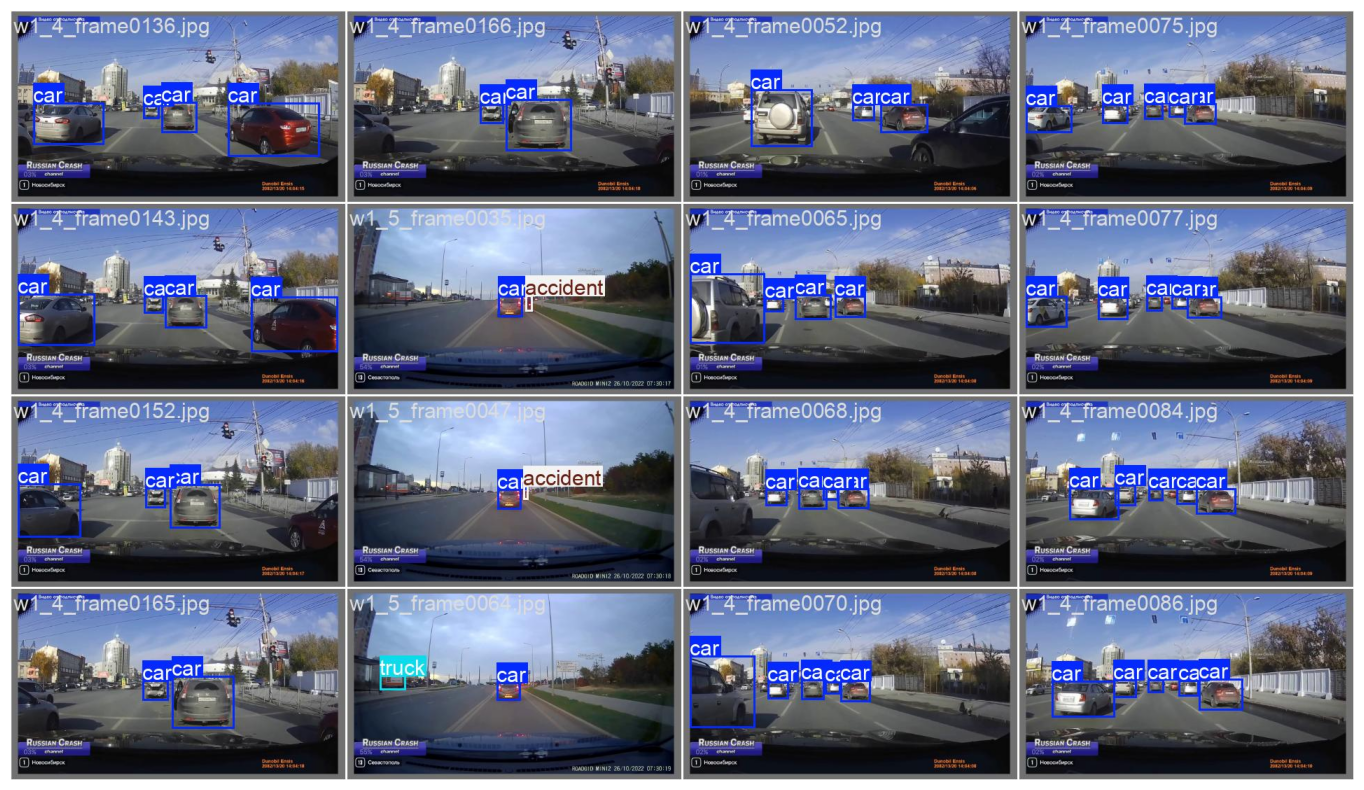

In [21]:
img_path = '/kaggle/working/runs/detect/train/train_batch4136.jpg'
img = plt.imread(img_path)

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis(False)
plt.show()

img_path = '/kaggle/working/runs/detect/train/val_batch1_labels.jpg'
img = plt.imread(img_path)

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis(False)
plt.show()